# Reviewing La ReUnion forecasts against IBTrACS and La ReUnion Best Track Data

This notebook reviews the forecast intensity by lead time using both IBTrACS and Best Track Data to understand how correctly the intensity is forecasted.

In [ ]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

from src.datasources import rsmc, helpers, codab
from src.utils import *
from src.constants import *

<Axes: >

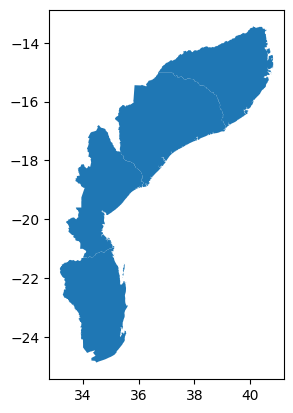

In [23]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [24]:
df = rsmc.load_historical_forecast_distances()

In [25]:
ibtracs_path = rsmc.DATA_DIR / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [26]:
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

<Axes: >

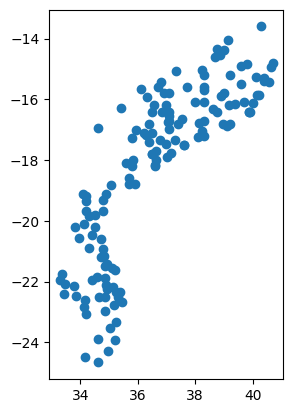

In [27]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel.plot()

In [28]:
df = df[df["name"].isin(all_storms)]

In [29]:
df.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MZ03_distance_km',
       'MZ07_distance_km', 'MZ09_distance_km', 'MZ11_distance_km'],
      dtype='object')

In [30]:
df["issue_time"].unique()

<DatetimeArray>
['2021-07-29 06:00:00+00:00', '2022-01-21 06:00:00+00:00',
 '2022-01-21 12:00:00+00:00', '2022-01-22 00:00:00+00:00',
 '2022-01-22 06:00:00+00:00', '2022-01-22 12:00:00+00:00',
 '2022-01-22 18:00:00+00:00', '2022-01-23 00:00:00+00:00',
 '2022-01-23 06:00:00+00:00', '2022-01-23 12:00:00+00:00',
 ...
 '2019-04-23 18:00:00+00:00', '2019-04-24 00:00:00+00:00',
 '2019-04-24 06:00:00+00:00', '2019-04-24 12:00:00+00:00',
 '2019-04-24 18:00:00+00:00', '2019-04-25 00:00:00+00:00',
 '2019-04-25 06:00:00+00:00', '2019-04-25 12:00:00+00:00',
 '2019-04-25 18:00:00+00:00', '2019-04-26 00:00:00+00:00']
Length: 484, dtype: datetime64[ns, UTC]

In [31]:
df_6hr = df[df["lt_hour"] % 6 == 0]

## Comparing against IBTrACS

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_ibtracs(
    gdf_points,
    df_6hr,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.ylim(1, 100)
plt.grid(True)
plt.show()

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_ibtracs(
    gdf_points,
    df_6hr,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine "correct_category" and "stronger_than_forecasted"
combined_metrics["correct_or_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

combined_metrics["percent_correct_or_stronger"] = (
    combined_metrics["correct_or_stronger"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct or stronger category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct_or_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.ylim(0, 100)
plt.title("Percentage of Correct or Stronger Storm Category by Lead Time")
plt.grid(True)
plt.show()

## Comparing against Best Track Data

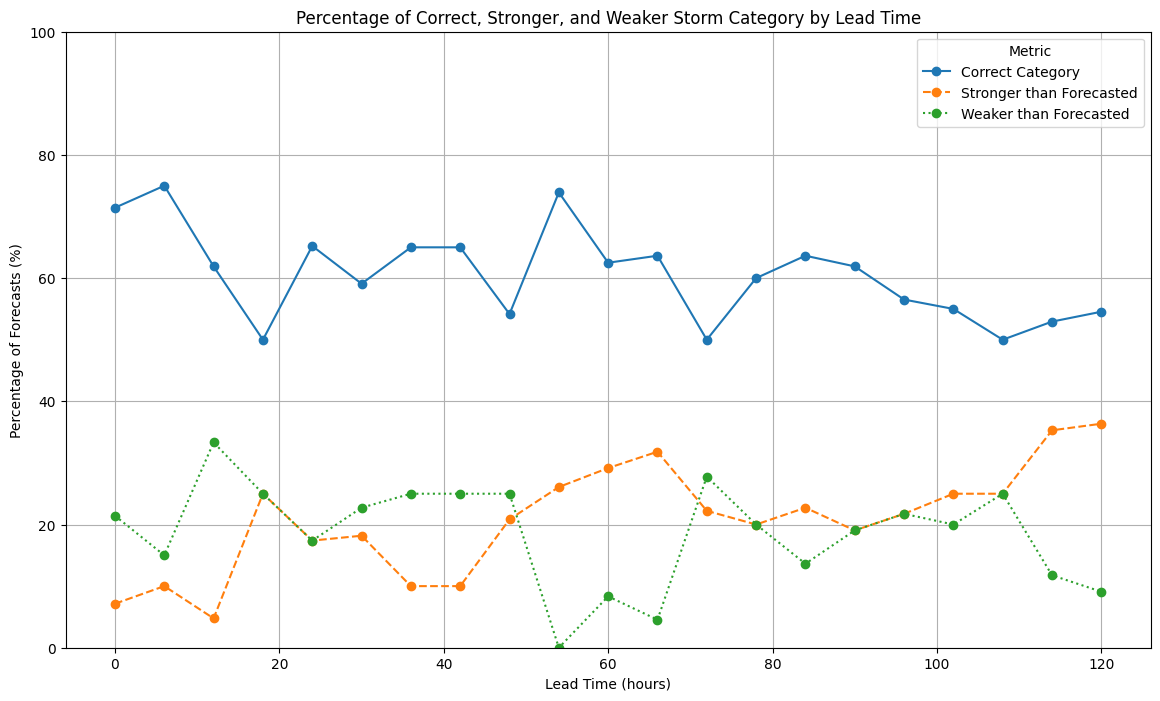

In [33]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_btdata(
    cyclone_tracks_sel,
    df,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

### Combining the Correct or Stronger Categories

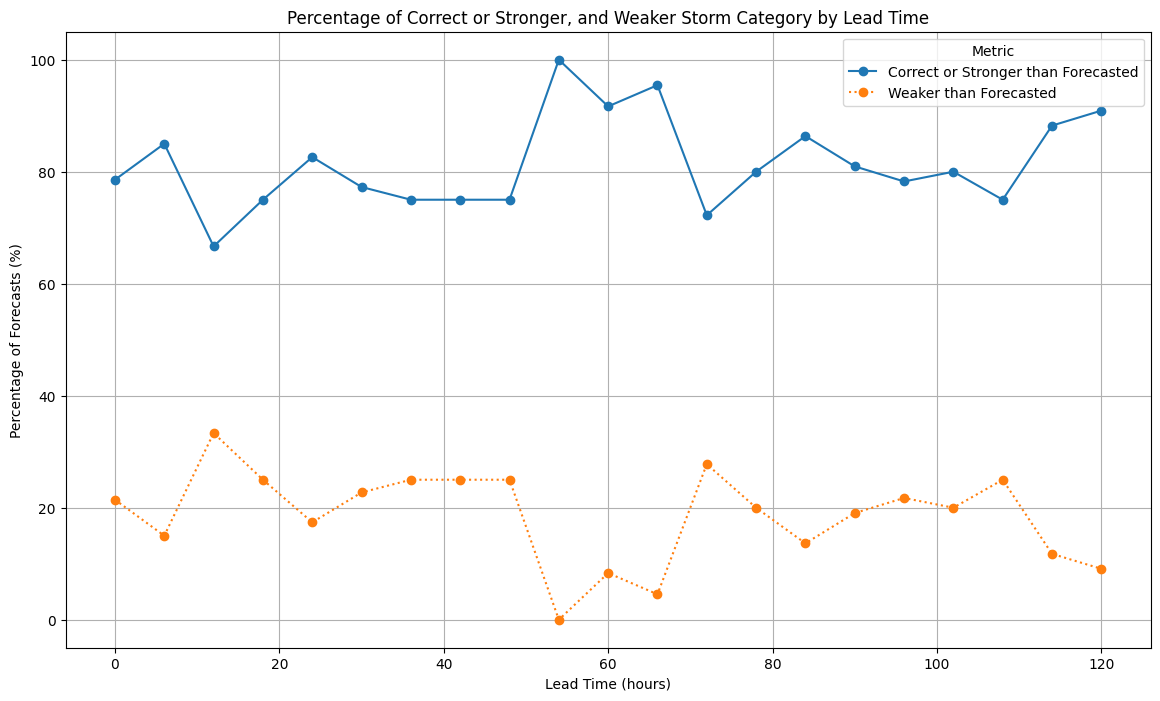

In [34]:
# Call the function to compute metrics
combined_metrics = helpers.calculate_metrics_by_category_mflr_btdata(
    cyclone_tracks_sel,
    df,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine correct and stronger than forecasted categories
combined_metrics["combined_correct_and_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

# Calculate percentages for combined category
combined_metrics["percent_combined_correct_stronger"] = (
    combined_metrics["combined_correct_and_stronger"]
    / combined_metrics["total_cases"]
    * 100
)

combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot combined correct and stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_combined_correct_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct or Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()